In [29]:
from augur.utils import json_to_tree
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import requests
import json

In [10]:
def tree_and_freqs_at_date(date):
    tree_url = f'https://nextstrain-blab.s3.amazonaws.com/ncov_adaptive-evolution_{date}.json'

    tree_json = requests.get(tree_url).json()

    #Put tree in Bio.Phylo format
    tree = json_to_tree(tree_json)

    with open(f'../ncov-workflow/auspice/ncov_adaptive-evolution_{date}_tip-frequencies.json') as f:
        frequencies = json.load(f)
        
    pivots = np.array(frequencies.pop("pivots"))
    
    
    frequency_arrays = {
        strain: np.array(strain_frequencies["frequencies"])
        for strain, strain_frequencies in frequencies.items()
        if "frequencies" in strain_frequencies
    }
    
    # add clade frequencies as an attribute of node
    for node in tree.find_clades(order="postorder"):
        if node.is_terminal():
            # We already know the frequencies of each terminal node, so
            # store those frequencies with the corresponding node of the tree.
            node.frequencies = frequency_arrays[node.name]
        else:
            # For each internal node, sum the frequencies of its immediate
            # children. Since we are walking through the tree from the bottom
            # up, each child node will always have frequencies calculated
            # before its parent node.
            node.frequencies = np.array([
                child.frequencies
                for child in node.clades
            ]).sum(axis=0)
        
    return tree, frequencies, pivots

In [27]:
def freq_of_mut(tree, mutation):
    """
    Find the most recent frequency of all clades with given mutation. Return the sum of all frequencies 
    (to give the frequency of the mutation on the whole tree at this time point)
    """
    
    gene = mutation.split(':')[0]
    mut = mutation.split(':')[1]
    
    clade_nodes_by_name = {}
    for node in tree.find_clades(terminal=False):
        if "clade_membership" in node.node_attrs:
            clade_name = node.node_attrs["clade_membership"]["value"]

            if clade_name not in clade_nodes_by_name:
                clade_nodes_by_name[clade_name] = node

    clade_nodes_with_mut_by_name = {}
    # only consider mutations occurring on internal branches with at least 15 descendents
    for node in tree.find_clades(terminal=False):
        if len(node.get_terminals())>=15:
            if (hasattr(node, "branch_attrs") and
                "mutations" in node.branch_attrs and 
                gene in node.branch_attrs["mutations"] and 
                any([mutation.endswith(mut) for mutation in node.branch_attrs["mutations"][gene]])):
                if node.name not in clade_nodes_by_name:
                    clade_nodes_with_mut_by_name[node.name] = node
                    
    # find number of occurrences
    num_occurrences = len(clade_nodes_with_mut_by_name)
    # find frequency of mut at most recent point               
    mut_frequency = 0

    for clade_name, clade_node in clade_nodes_with_mut_by_name.items():
        most_recent_freq = clade_node.frequencies[-1]
        mut_frequency+=most_recent_freq
        
    return num_occurrences, mut_frequency

In [43]:
def mut_freq_over_time(dates, mutations):
    
    mut_info_over_time = []
    
    for date in dates:
        for mutation in mutations:
            tree, frequencies, pivots = tree_and_freqs_at_date(date)
            num_occurrences, mut_frequency = freq_of_mut(tree, mutation)
            mut_info_over_time.append({'date': date, 'mutation':mutation, 'num_occurrences': num_occurrences, 
                                       'frequency': mut_frequency})
        
    df = pd.DataFrame(mut_info_over_time)
    
    cmap= {'S:501Y':'green', 'ORF1a:3675-':'orange', 'ORF1a:3255I':'blue', 
           'S:452R':'red', 'S:681H':'purple', 'S:484K':'yellow', 'S:95I':'pink'}
    
    g = sns.FacetGrid(df, hue="mutation", size=8, palette=cmap)
    g.map(plt.scatter, 'num_occurrences', 'frequency')
    g.map(plt.plot, 'num_occurrences', 'frequency')

#     sns.scatterplot(x='num_occurrences', y='frequency', hue='mutation', data=df)

#     for mut in mutations:
#         plt.plot('num_occurrences', 'frequency', data=df[df['mutation']==mut], marker='o', 
#                  ax=ax, color = cmap[mut])

/Users/katekistler/anaconda3/envs/ncov/lib/python3.6/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


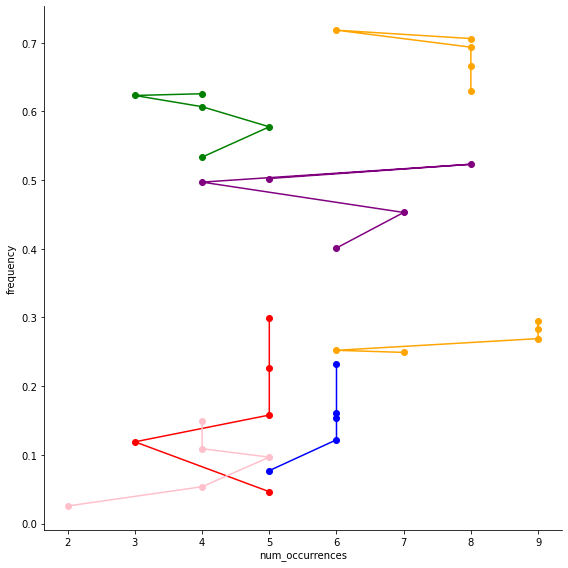

In [42]:
mut_freq_over_time(['2021-04-15','2021-05-01', '2021-05-15', '2021-06-01', '2021-06-15'], 
                   ['S:501Y', 'ORF1a:3675-', 'ORF1a:3255I', 'S:452R', 'S:681H', 'S:484K', 'S:95I'])